# Simple Model Training
This script is used to generate a simple CNN tensorflow model, train it and print the results

In [37]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras import layers
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [38]:
# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

The data is loaded from two ```.csv``` files and is already divided into labeled samples. Each row contains one ECG sample: columns 0 to 186 are the ECG reading and 187 is the sample classification:
    
    ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [39]:
# Load data from file
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

#train_df.head()
#train_df.tail()

The data is divided into training and testing datasets and from each is extracted the vector containing the sample labels

In [40]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

The CNN model is defined

In [41]:
# Network Architecture Search with Tensorflow

def build_model(hp):
  model = keras.Sequential()
  
  # Standard input layer
  model.add(keras.layers.Input(shape=((X_train.shape[1],1)), name='inputs_cnn'))

  # Tune whether to use convolutional layers
  if hp.Boolean("conv_1"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_1", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_1", min_value=3, max_value=15, step=2),
                                          strides=hp.Int("strides_1", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
  
  if hp.Boolean("maxpool_1"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_1", min_value=1, max_value=6, step=1)))

  if hp.Boolean("conv_2"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_2", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_2", min_value=3, max_value=7, step=2),
                                          strides=hp.Int("strides_2", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
    
  if hp.Boolean("maxpool_2"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_2", min_value=1, max_value=6, step=1)))

  if hp.Boolean("conv_3"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_3", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_3", min_value=3, max_value=7, step=2),
                                          strides=hp.Int("strides_3", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
  
  # Flatten before dense layers
  model.add(keras.layers.Flatten(name="flat_1"))

  # Fixed dense layers
  model.add(keras.layers.Dense(30, activation='softmax', name='dense_1'))  
  model.add(keras.layers.Dense(5, activation='softmax', name='main_output'))

  # Tune the learning rate 
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )

  return model

build_model(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=40,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="alg_8_peaks_nn",
)

tuner.search(X_train, y_train, epochs=4, validation_data=(X_test, y_test))




Trial 20 Complete [00h 01m 05s]
val_accuracy: 0.8276082873344421

Best val_accuracy So Far: 0.8740864396095276
Total elapsed time: 00h 20m 30s

Search: Running Trial #21

Value             |Best Value So Far |Hyperparameter
False             |True              |conv_1
True              |False             |maxpool_1
False             |False             |conv_2
False             |True              |maxpool_2
True              |True              |conv_3
0.00012112        |0.0043429         |lr
3                 |4                 |filters_1
13                |3                 |kernel_size_1
1                 |5                 |strides_1
2                 |1                 |filters_2
5                 |5                 |kernel_size_2
7                 |5                 |strides_2
2                 |1                 |pool_size_2
2                 |1                 |filters_3
5                 |5                 |kernel_size_3
5                 |5                 |strides_3
4         

KeyboardInterrupt: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 38, 4)          │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 38, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 8, 1)           │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 462 (1.80 KB)

 Trainable params: 462 (1.80 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 8
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9252 - loss: 0.2896 - val_accuracy: 0.9229 - val_loss: 0.2947
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9258 - loss: 0.2885 - val_accuracy: 0.9218 - val_loss: 0.2985
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9252 - loss: 0.2871 - val_accuracy: 0.9261 - val_loss: 0.2882
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9263 - loss: 0.2857 - val_accuracy: 0.9251 - val_loss: 0.2896
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9257 - loss: 0.2889 - val_accuracy: 0.9218 - val_loss: 0.2914
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9241 - loss: 0.2892 - val_accuracy: 0.9213 - val_loss: 0.2935
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9267 - loss: 0.2834 - val_accuracy: 0.9265 - val_loss: 0.2854
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9278 -

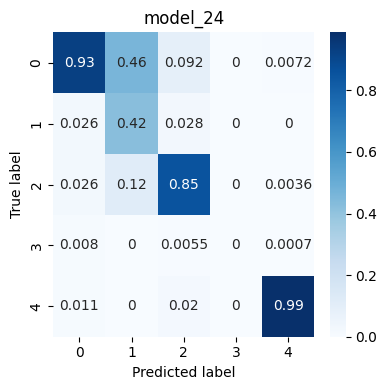

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 186, 5)         │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 1)          │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551 (2.15 KB)

 Trainable params: 551 (2.15 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 11
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9192 - loss: 0.3237 - val_accuracy: 0.9211 - val_loss: 0.3104
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9203 - loss: 0.3028 - val_accuracy: 0.9157 - val_loss: 0.3072
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9192 - loss: 0.2893 - val_accuracy: 0.9230 - val_loss: 0.2873
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9257 - loss: 0.2624 - val_accuracy: 0.9306 - val_loss: 0.2501
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9317 - loss: 0.2363 - val_accuracy: 0.9344 - val_loss: 0.2369
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9345 - loss: 0.2277 - val_accuracy: 0.9339 - val_loss: 0.2270
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9334 - loss: 0.2283 - val_accuracy: 0.9381 - val_loss: 0.2215
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9369

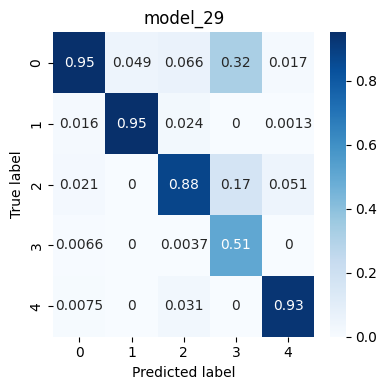

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 62, 1)          │            14 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 499 (1.95 KB)

 Trainable params: 499 (1.95 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 10
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8753 - loss: 0.4317 - val_accuracy: 0.8774 - val_loss: 0.4222
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8777 - loss: 0.4168 - val_accuracy: 0.8858 - val_loss: 0.4007
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8857 - loss: 0.3981 - val_accuracy: 0.8897 - val_loss: 0.3842
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8897 - loss: 0.3829 - val_accuracy: 0.8931 - val_loss: 0.3692
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8932 - loss: 0.3656 - val_accuracy: 0.9009 - val_loss: 0.3483
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9035 - loss: 0.3384 - val_accuracy: 0.9058 - val_loss: 0.3304
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9034 - loss: 0.3344 - val_accuracy: 0.9077 - val_loss: 0.3184
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9078 

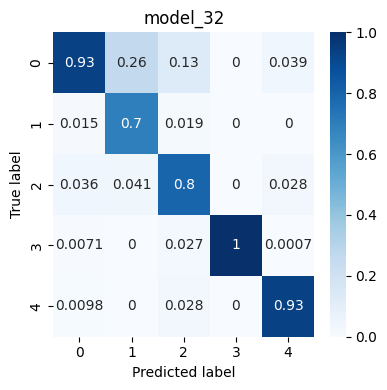

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling1d (MaxPooling1D)    │ (None, 31, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 31)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,115 (4.36 KB)

 Trainable params: 1,115 (4.36 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 31
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.8706 - loss: 0.4670 - val_accuracy: 0.8724 - val_loss: 0.4680
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8729 - loss: 0.4600 - val_accuracy: 0.8757 - val_loss: 0.4530
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8777 - loss: 0.4450 - val_accuracy: 0.8790 - val_loss: 0.4418
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8809 - loss: 0.4335 - val_accuracy: 0.8799 - val_loss: 0.4295
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8841 - loss: 0.4218 - val_accuracy: 0.8873 - val_loss: 0.4158
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8864 - loss: 0.4163 - val_accuracy: 0.8920 - val_loss: 0.4029
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8902 - loss: 0.4015 - val_accuracy: 0.8942 - val_loss: 0.3922
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.8939 

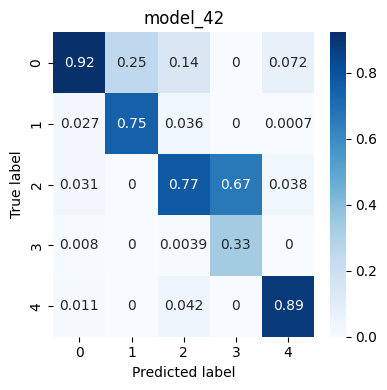

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 62, 5)          │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 20, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,030 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,235 (12.64 KB)

 Trainable params: 3,235 (12.64 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 100


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 27, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 2)           │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261 (1.02 KB)

 Trainable params: 261 (1.02 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 2
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8574 - loss: 0.4335 - val_accuracy: 0.8612 - val_loss: 0.4344
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8592 - loss: 0.4318 - val_accuracy: 0.8630 - val_loss: 0.4325
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8590 - loss: 0.4315 - val_accuracy: 0.8587 - val_loss: 0.4357
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8608 - loss: 0.4294 - val_accuracy: 0.8633 - val_loss: 0.4297
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8595 - loss: 0.4319 - val_accuracy: 0.8630 - val_loss: 0.4304
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8604 - loss: 0.4288 - val_accuracy: 0.8631 - val_loss: 0.4297
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8615 - loss: 0.4281 - val_accuracy: 0.8633 - val_loss: 0.4297
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8594 -

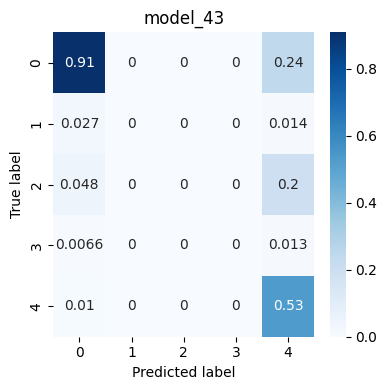

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 186, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 186, 1)         │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 186, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 186)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         5,610 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,773 (22.55 KB)

 Trainable params: 5,773 (22.55 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 186


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 62, 1)          │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 62)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         1,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 62


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 62, 2)          │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 2)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 124)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,937 (15.38 KB)

 Trainable params: 3,937 (15.38 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 124


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 186, 4)         │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 46, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 4)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 2, 4)           │            52 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_1 (Flatten)                │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           270 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 493 (1.93 KB)

 Trainable params: 493 (1.93 KB)

 Non-trainable params: 0 (0.00 B)

CNN out size: 8
Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8268 - loss: 0.6601 - val_accuracy: 0.8276 - val_loss: 0.6603
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8270 - loss: 0.6599 - val_accuracy: 0.8276 - val_loss: 0.6602
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8245 - loss: 0.6664 - val_accuracy: 0.8276 - val_loss: 0.6603
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8271 - loss: 0.6601 - val_accuracy: 0.8276 - val_loss: 0.6602
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8302 - loss: 0.6520 - val_accuracy: 0.8276 - val_loss: 0.6602
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8269 - loss: 0.6597 - val_accuracy: 0.8276 - val_loss: 0.6601
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8285 - loss: 0.6557 - val_accuracy: 0.8276 - val_loss: 0.6601
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.829

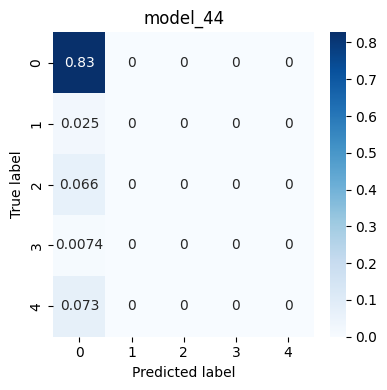

In [42]:
# All models in which the convolution output is less than MAX_CNN_OUT
NUM_MODELS = 10
MAX_CNN_OUT = 55
models = tuner.get_best_models(num_models=NUM_MODELS)
for curr_model in models:
    curr_model.summary()
    layer = curr_model.get_layer('flat_1')
    cnn_output_shape = layer.compute_output_shape(layer.input.shape)[1]
    print("CNN out size: " + str(cnn_output_shape))
    # If flat layer is smaller than maximum size
    if cnn_output_shape < MAX_CNN_OUT:
        # Disable filtering for error messages
        keras.config.disable_traceback_filtering()

        # Assign available number to current model
        model_num = 0
        while os.path.exists("models/cnn/model_%s.keras" % f"{model_num:02}"):
            model_num += 1
        log_dir = "logs/cnn/"
        #tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

        # Train model
        #history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test), callbacks=[tensorboard_callback])
        history=curr_model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test))

        # Save trained model
        model_name = 'model_'+ str(f"{model_num:02}")
        model_path = 'models/cnn/' + model_name + '.keras'
        curr_model.name = model_name
        curr_model.save(model_path)

        # Predict using current model
        y_prediction = curr_model.predict(X_test)
        y_prediction = np.argmax (y_prediction, axis = 1)
        y_test_tmp=np.argmax(y_test, axis=1)

        # Create confusion matrix and normalize it over predicted (columns)
        result = confusion_matrix(y_test_tmp, y_prediction , normalize='pred')
        classes = [0,1,2,3,4]
        result_norm = np.around(result, 4)
        mat_result = pd.DataFrame(result_norm,
                            index = classes, 
                            columns = classes)

        total_pred = np.trace(result) / 5

        print('Confusion matrix')
        print(mat_result)
        print()
        print('Average accuracy')
        print(total_pred)

        # Save confusion matrix picture
        figure = plt.figure(figsize=(4, 4))
        sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
        plt.title(model_name)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
        plt.show()
